# Token Patching

In [1]:
#@title Import libraries
import transformer_lens
import torch, gc, itertools, functools, tqdm, copy
import pandas as pd
import numpy as np
from typing import Callable

import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
torch.set_grad_enabled(False)

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

#mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

import sys
sys.path.append('/home/jupyter/')
from paraMem.utils import modelHandlers, dataLoaders, gradient, evaluation, localizing, intervening

## Model

In [59]:
model = modelHandlers.load_model(model_type="gpt-neo-125M", DEVICE="cuda", lr=0.0, weight_decay=0.01)

Loaded pretrained model gpt-neo-125M into HookedTransformer
setting no_grad on ['embed', 'pos_embed', 'unembed', 'b_in', 'b_out', 'b_K', 'b_Q', 'b_V', 'b_O']


## Data

In [60]:
(mem_prompts, mem_counts),(non_mem_prompts,non_mem_counts) = dataLoaders.load_pile_splits("acc/gpt-neo-125M", as_torch=True)
train_dl, test_dl = dataLoaders.train_test_batching(mem_prompts, non_mem_prompts, mem_batch=1, non_mem_batch=1, test_frac=0.2, add_bos=None)
c_toks_NI, k_toks_NI = next(iter(train_dl))
c_toks_NI, k_toks_NI = c_toks_NI.squeeze(0), k_toks_NI.squeeze(0)

from /home/jupyter/paraMem/data/pile_splits/acc/gpt-neo-125M loading ['mem.pt', 'non_mem.pt']...


In [61]:
#prompt = "Our Father, who art in heaven, hallowed be thy name; thy kingdom come; thy will be done; on earth as it is in heaven. Give us this day our daily bread. And forgive us our trespasses, as we forgive those who trespass against us. And lead us not into temptation; but deliver us from evil"
#prompt = "An apple a day keeps the doctor away"
#tokens_NI = model.to_tokens(prompt, prepend_bos=True)
toks_NI = c_toks_NI
print(model.to_string(toks_NI))
pref_cont_split = 50#int(tokens_NI.shape[-1] / 2)
pref_NI = toks_NI[:,:pref_cont_split]

['\n====================\n\nThe authors declare no conflict of interest.\n\nSupporting information\n======================\n\nAs a service to our authors and readers, this journal provides supporting information supplied by the authors. Such materials are peer reviewed and may be re‐organized for online delivery, but are not copy‐edited or typeset. Technical support issues arising from supporting information (other than missing files) should be addressed to the authors.\n\n###### \n\nSupplementary\n\n######']


In [62]:
def get_first2sec_tok(logits_NIT:torch.Tensor, prefix_NI:torch.Tensor, keepNonTop:bool=True):
    """
    pertubate sequence via first and second most likely tokens
    """
    scores_NIT = (torch.nn.functional.softmax(logits_NIT.to("cpu"), dim=-1))
    prefix_scores_NI = modelHandlers.gather_token_scores(scores_NIT, prefix_NI)
    top_scores_Ik, top_idcs_Ik = modelHandlers.get_topK(scores_NIT, topK=2, minK=False)
    
    pertubed_prefix = torch.clone(prefix_NI[:,1:]).long()
    prefixIsTop = torch.where(top_idcs_Ik[...,:-1,0] == prefix_NI[:,1:], 1, 0)
    pertubed_prefix[prefixIsTop.bool()] = top_idcs_Ik[...,:-1,1][prefixIsTop.bool()] ## pick top 2
    if keepNonTop:
        pertubed_prefix[~prefixIsTop.bool()] = top_idcs_Ik[...,:-1,0][~prefixIsTop.bool()] ## pick top 1
    
    ## add BOS token
    bos_N = prefix_NI[:,0].unsqueeze(-1)
    pertubed_prefix = torch.cat((bos_N, pertubed_prefix), dim=-1)
    return pertubed_prefix
    
def get_random_tok(prefix_NI:torch.Tensor, vocab_size:int=50257, seed:int=0): 
    """
    pertubate sequence via random tokens (vocab_size = model.cfg.d_vocab)
    """
    if seed >= 0:
        print(f"fixed torch seed {seed}")
        torch.manual_seed(seed)
    pertubed_prefix = torch.randint(0, vocab_size, prefix_NI.shape)[...,:-1]
    
    ## add BOS token
    bos_N = prefix_NI[:,0].unsqueeze(-1)
    pertubed_prefix = torch.cat((bos_N, pertubed_prefix), dim=-1)
    return pertubed_prefix

#pertubed_prefix_NI = get_first2sec_tok(model(toks_NI[:,:pref_cont_split]).to("cpu"), prefix_NI, keepNonTop=True)
#print(model.to_string(pertubed_prefix_NI), pertubed_prefix_NI.shape)

pertubed_pref_NI = get_random_tok(pref_NI, vocab_size= model.cfg.d_vocab, seed=-1)
print(model.to_string(pertubed_pref_NI), pertubed_pref_NI.shape)

['\n greatlyidency Prel lithium climaxATIONAL Gest utmost blueム 1913 cuts commoditiesPsych Dor FDA Strawberry CASVeruddingadvant 1964umbledore secession expressing thorreatment Seal476 Medals Transfer Boot grindingballsretch boneller drastic plans restrooms worked perspectives upkeep JamalizonsresourcesAmount pharmacy recru'] torch.Size([1, 50])


In [67]:
def token_patching_loop(model, toks_NI=torch.tensor, pertubed_pref_NI=torch.tensor, decode:bool=False, single_tok_perturb:bool=True, disable_tqdm:bool=False):
    """
    loop over all tokens in the prefix, pertubate them and measure the change in the continuation
    """
    with torch.no_grad():
        pref_NI, cont_NI, n_toks = toks_NI[:,:pertubed_pref_NI.shape[-1]], toks_NI[:,-pertubed_pref_NI.shape[-1]:], pertubed_pref_NI.shape[-1]

        nll_metric, em_metric = torch.zeros(pref_NI.shape[0], pref_NI.shape[-1]), torch.zeros(pref_NI.shape[0], pref_NI.shape[-1])
        toks_NI = torch.cat((pref_NI, cont_NI), dim=-1)
        orig_toks_nll = modelHandlers.gather_token_scores(modelHandlers.NegLogLik(model(toks_NI.to(model.cfg.device)).to("cpu")), toks_NI)

        interv_tok_pos, min_em, most_changed_preds = torch.zeros(cont_NI.shape[0]).long(), torch.ones(cont_NI.shape[0])*9999, torch.zeros(cont_NI.shape).long()
        for tok_pos in tqdm.tqdm(range(n_toks), total=n_toks, disable=disable_tqdm):

            ## (1) intervene on token at token position
            pref_NI_interv = torch.clone(pref_NI)
            if single_tok_perturb:
                pref_NI_interv[:,tok_pos] = pertubed_pref_NI[:,tok_pos]
            else:
                pref_NI_interv[:,:tok_pos] = pertubed_pref_NI[:,:tok_pos]

            ## (2) generate continuation on intervened token sequence
            if decode: #[:,:prefix_NI.shape[-1]]
                pred_toks_NI = model.generate(input=pref_NI_interv, use_past_kv_cache=True, stop_at_eos=False, max_new_tokens=cont_NI.shape[-1], do_sample=False)
                pred_nll_NIT = modelHandlers.NegLogLik(model(pred_toks_NI).detach().to("cpu"))
                pred_nll_NI = modelHandlers.gather_token_scores(pred_nll_NIT, pred_toks_NI.to("cpu"))

                pred_toks_NI = pred_toks_NI[:,-cont_NI.shape[-1]:].to("cpu")
                cont_NI_test = torch.clone(cont_NI).to("cpu")


            else: ## argmax decoding
                toks_NI_interv = torch.cat((pref_NI_interv, cont_NI), dim=-1)
                pred_nll_NIT = modelHandlers.NegLogLik(model(toks_NI_interv.to(model.cfg.device)).to("cpu"))

                pred_nll_NI = modelHandlers.gather_token_scores(pred_nll_NIT, toks_NI) ## get pred NLL 
                _, pred_toks_NIk = modelHandlers.get_topK(pred_nll_NIT, topK=1, minK=True) ## get argmax toks 
                pred_toks_NI = pred_toks_NIk[...,-(cont_NI.shape[-1]+1):-1,0].to("cpu")
                cont_NI_test = torch.clone(cont_NI[...,:]).to("cpu")

            ## (3) evaluate the generated continuation against the original continuation
            nll_metric[:,tok_pos] = pred_nll_NI[:,-cont_NI.shape[-1]:].mean(-1)   

            em = evaluation.compute_exact_match(pred_toks_NI, cont_NI_test, until_wrong=False)
            em_metric[:,tok_pos] = em

            ## (4) update minimum em and most_changed_preds
            select_mask = torch.where(em < min_em, 1, 0)
            select_idcs = torch.nonzero(select_mask.bool()).squeeze()
            interv_tok_pos[select_idcs] = tok_pos
            min_em[select_idcs] = em[select_idcs]
            most_changed_preds[select_idcs,:] = pred_toks_NI[select_idcs,:].detach()        
    return nll_metric, em_metric, most_changed_preds, interv_tok_pos

nll_metric, em_metric, most_changed_preds, min_tok_pos = token_patching_loop(model, toks_NI, pertubed_pref_NI, single_tok_perturb=False, decode=True)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:14,  1.53s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  4%|▍         | 2/50 [00:03<01:12,  1.51s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  6%|▌         | 3/50 [00:04<01:10,  1.49s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  8%|▊         | 4/50 [00:05<01:08,  1.49s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 10%|█         | 5/50 [00:07<01:06,  1.49s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 12%|█▏        | 6/50 [00:08<01:05,  1.48s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 14%|█▍        | 7/50 [00:10<01:04,  1.50s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 16%|█▌        | 8/50 [00:11<01:02,  1.50s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 18%|█▊        | 9/50 [00:13<01:01,  1.50s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 20%|██        | 10/50 [00:14<01:00,  1.50s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 22%|██▏       | 11/50 [00:16<00:58,  1.50s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 24%|██▍       | 12/50 [00:17<00:56,  1.50s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 26%|██▌       | 13/50 [00:19<00:55,  1.51s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 28%|██▊       | 14/50 [00:21<00:54,  1.52s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 30%|███       | 15/50 [00:22<00:53,  1.52s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 32%|███▏      | 16/50 [00:24<00:51,  1.51s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 34%|███▍      | 17/50 [00:25<00:49,  1.51s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 36%|███▌      | 18/50 [00:27<00:47,  1.49s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 38%|███▊      | 19/50 [00:28<00:45,  1.48s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 40%|████      | 20/50 [00:29<00:43,  1.46s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 42%|████▏     | 21/50 [00:31<00:42,  1.45s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 44%|████▍     | 22/50 [00:32<00:40,  1.44s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 46%|████▌     | 23/50 [00:34<00:39,  1.47s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 48%|████▊     | 24/50 [00:35<00:38,  1.49s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 50%|█████     | 25/50 [00:37<00:36,  1.47s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 52%|█████▏    | 26/50 [00:38<00:34,  1.45s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 54%|█████▍    | 27/50 [00:40<00:33,  1.44s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 56%|█████▌    | 28/50 [00:41<00:31,  1.44s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 58%|█████▊    | 29/50 [00:42<00:30,  1.43s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 60%|██████    | 30/50 [00:44<00:28,  1.43s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 62%|██████▏   | 31/50 [00:45<00:27,  1.43s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 64%|██████▍   | 32/50 [00:47<00:25,  1.43s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 66%|██████▌   | 33/50 [00:48<00:24,  1.43s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 68%|██████▊   | 34/50 [00:50<00:22,  1.43s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 70%|███████   | 35/50 [00:51<00:21,  1.43s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 72%|███████▏  | 36/50 [00:52<00:19,  1.43s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 74%|███████▍  | 37/50 [00:54<00:18,  1.43s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 76%|███████▌  | 38/50 [00:55<00:17,  1.42s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 78%|███████▊  | 39/50 [00:57<00:15,  1.42s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 80%|████████  | 40/50 [00:58<00:14,  1.42s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 82%|████████▏ | 41/50 [00:59<00:12,  1.41s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 84%|████████▍ | 42/50 [01:01<00:11,  1.43s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 86%|████████▌ | 43/50 [01:02<00:09,  1.42s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 88%|████████▊ | 44/50 [01:04<00:08,  1.42s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 90%|█████████ | 45/50 [01:05<00:07,  1.45s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 92%|█████████▏| 46/50 [01:07<00:06,  1.59s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 94%|█████████▍| 47/50 [01:09<00:04,  1.60s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 96%|█████████▌| 48/50 [01:12<00:04,  2.08s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 98%|█████████▊| 49/50 [01:15<00:02,  2.39s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [01:17<00:00,  1.55s/it]


In [68]:
nll_baseline = nll_metric[...,0,0].mean().item()
em_baseline = em_metric[...,0,0].mean().item()

nll = nll_metric[...,0,:].numpy()
em = em_metric[...,0,:].numpy()

x = np.arange(0,em.shape[-1])
true_prefix=model.to_str_tokens(pref_NI.squeeze())
pertubed_prefix=model.to_str_tokens(pertubed_pref_NI.squeeze())

xlabels = true_prefix
#xlabels = [a + r" $\rightarrow$ " + b for (a,b) in zip(true_prefix, pertubed_prefix)]

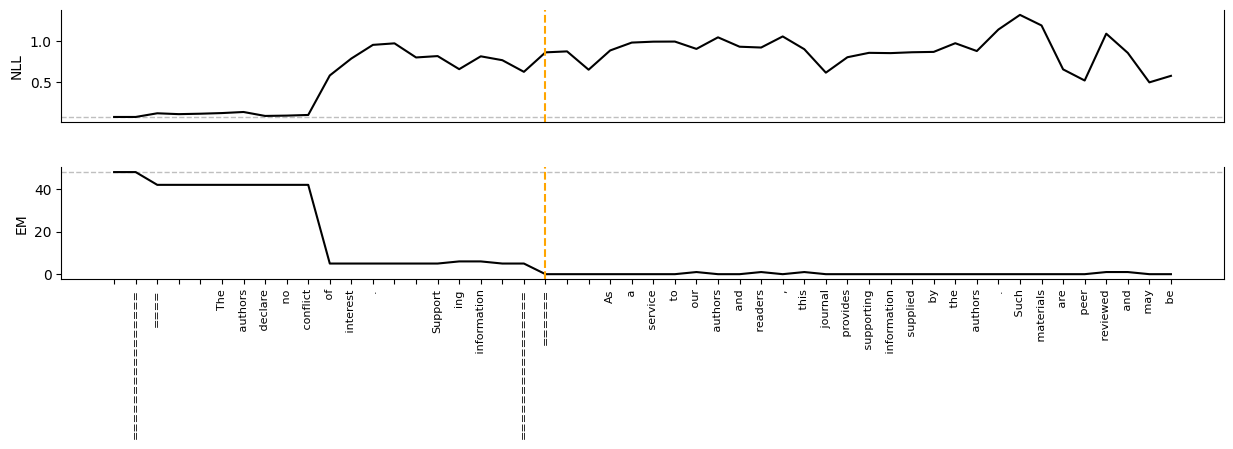

In [69]:
fig, ax = plt.subplots(2, 1, figsize=(15, 3.5), gridspec_kw={'hspace': 0.4})
fontsize = 10

ax[0].axhline(y=nll_baseline, linewidth=1, linestyle='--', c="grey", alpha=0.5)
ax[0].plot(x, nll, c="black")
ax[0].set_ylabel(r'NLL', fontsize=fontsize) #\searrow
ax[0].set_xticks([])
#ax[0].yscale("log")
ax[0].axvline(x=min_tok_pos, c="orange", linestyle='--')


ax[1].axhline(y=em_baseline, linewidth=1, linestyle='--', c="grey", alpha=0.5)
ax[1].plot(x, em, c="black")
ax[1].set_ylabel(r'EM', fontsize=fontsize) #\searrow
ax[1].axvline(x=min_tok_pos, c="orange", linestyle='--')

ax[1].set_xticks(x)
labels = ax[1].set_xticklabels(xlabels, fontsize=fontsize-2, rotation=90)

In [15]:
#nll_NI = modelHandlers.gather_tokenr_scores(model(tokens_NI), tokens_NI) ## get pred NLL 
logs = model(c_toks_NI)
_, pred_k = modelHandlers.get_topK(logs, topK=1, minK=False) ## get argmax toks 
model.to_string(pred_k[...,0])

['.\n    ns:http://www.sun.com/xml/ns/jee"\nns:x="http://java.sun.com/xml/ns/javaee/web-agg_2_0.xsd"\n    xmlsi:schemaLocation="http://java.sun.com/xml/ns/javaee http://java.sun.com/xml/ns/javaee/web-app_2_']